##**Date:** 21-12-22 



##**Task:** 
The goal of this project is to build a machine learning model that can help bean farmers mainly in Africa, detect bean leaves with defects early enough.

# Importing the required Libraries

In [67]:
import tensorflow as tf                             # An open source library to for deep learning  
from IPython.display import Image, display          # Public API for display tools in IPython.

In [68]:
tf.__version__                                      # To check the version of the module

'2.9.2'

In [69]:
import matplotlib.pyplot as plt                     # Library for visualizations
import tensorflow_hub as hub                        # It is a repository of trained machine learning models.
import numpy as np                                  # To work with arrays and perform mathematical operations
import warnings                                     # This library is used for suppressing the warnings
warnings.filterwarnings('ignore')  

In [70]:
from PIL import Image                               # The Python Imaging Library which provides the python interpreter with image editing capabilities
from skimage import transform                       # This object contains parameters for transformation

# Importing the Dataset.

1. Downloading the zip files from google api storage

In [5]:
# This is generally written on the command line, the exclamation mark here runs the code on the terminal.
# train data
!wget https://storage.googleapis.com/ibeans/train.zip
# Validation data
!wget https://storage.googleapis.com/ibeans/validation.zip
# Test data
!wget https://storage.googleapis.com/ibeans/test.zip

--2022-12-21 16:53:12--  https://storage.googleapis.com/ibeans/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.128, 142.250.145.128, 74.125.143.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143812152 (137M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 137.15M  34.9MB/s    in 4.6s    

2022-12-21 16:53:17 (29.9 MB/s) - ‘train.zip’ saved [143812152/143812152]

--2022-12-21 16:53:17--  https://storage.googleapis.com/ibeans/validation.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.128, 142.250.145.128, 74.125.143.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18504213 (18M) [application/zip]
Saving to: ‘validation.zip’

validation.zip      100%[=================

2. Making a directory where the files could be unzipped.

In [6]:
!mkdir beans # Making a directory

3. Finally unzipping the files inside the created directory.

In [7]:
!unzip train.zip -d beans/
!unzip test.zip -d beans/
!unzip validation.zip -d beans/

Archive:  train.zip
   creating: beans/train/
   creating: beans/train/healthy/
   creating: beans/train/angular_leaf_spot/
   creating: beans/train/bean_rust/
  inflating: beans/train/healthy/healthy_train.265.jpg  
  inflating: beans/train/healthy/healthy_train.271.jpg  
  inflating: beans/train/healthy/healthy_train.259.jpg  
  inflating: beans/train/healthy/healthy_train.99.jpg  
  inflating: beans/train/healthy/healthy_train.311.jpg  
  inflating: beans/train/healthy/healthy_train.66.jpg  
  inflating: beans/train/healthy/healthy_train.72.jpg  
  inflating: beans/train/healthy/healthy_train.305.jpg  
  inflating: beans/train/healthy/healthy_train.339.jpg  
  inflating: beans/train/healthy/healthy_train.113.jpg  
  inflating: beans/train/healthy/healthy_train.107.jpg  
  inflating: beans/train/healthy/healthy_train.106.jpg  
  inflating: beans/train/healthy/healthy_train.112.jpg  
  inflating: beans/train/healthy/healthy_train.338.jpg  
  inflating: beans/train/healthy/healthy_trai

##Finding the number of files in the folder. The structure of the code is:
1. find- finding files and folders
2. files/folders - file in which the command will 'find'.
3. -type f tells find to look only for files
4. wc is a program to count characters, words, and lines in some text,
5. | sends the output of find to wc
6. -l tells it to only count lines.

1. Total number of files

In [8]:
!find beans -type f | wc -l

1296


2. Total number of files/image in the folder train

In [9]:
!find beans/train -type f | wc -l

1035


3. Total number of files/image in the folder test.

In [10]:
!find beans/test -type f | wc -l

128


4. Total number of files/image in the folder validation.

In [11]:
!find beans/validation -type f | wc -l

133


## Exploring the data

1. Image of a healthy leave.

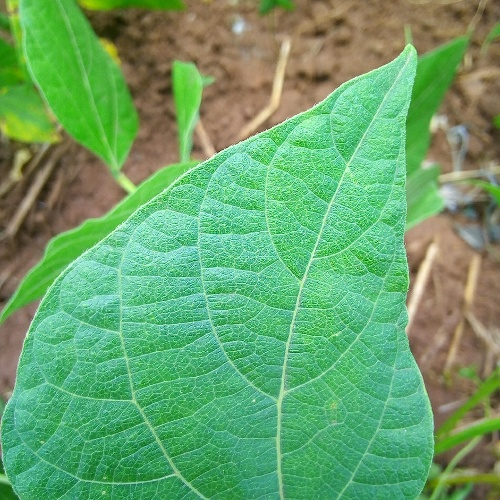

In [17]:
display(Image('beans/train/healthy/healthy_train.0.jpg'))

2. Image of a leave with angular leaf spot disease.

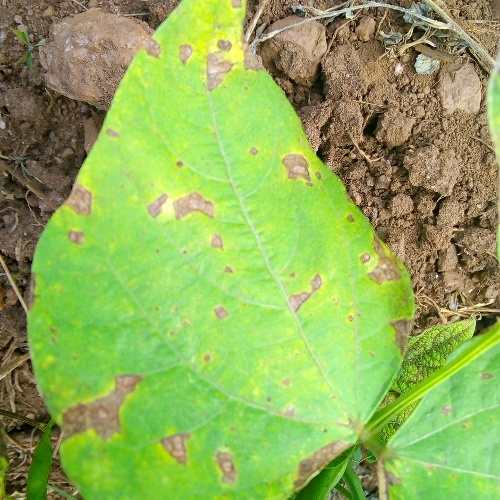

In [18]:
display(Image('beans/train/angular_leaf_spot/angular_leaf_spot_train.124.jpg'))

3. Image of the crop's leave with bean rust disease.

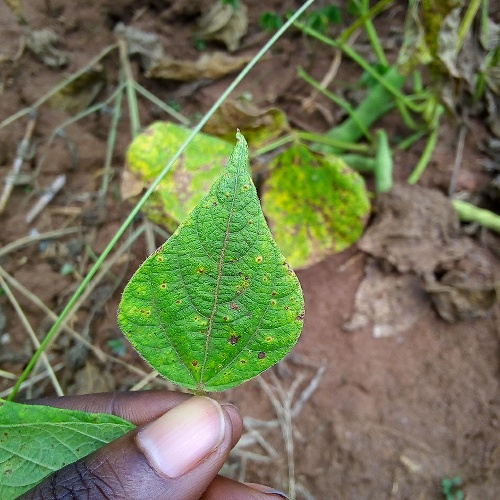

In [19]:
display(Image('beans/train/bean_rust/bean_rust_train.162.jpg'))

# Preparing the dataset for modelling.

Since we are gonna use mobile net V2 for modelling, we would convert the image so that it could be compatible with the model.

In [20]:
batch_size = 128
img_height = 224
img_width = 224

 By using tf.keras.preprocessing.image_dataset_from_directory will return a tf.data.Dataset that yields batches of images from the subdirectories.

 **Here, since we didnot specify 'label' parameter, it is by default taken as 'inferred' which generates the label from the directory structure.**

 1. Train Data

In [21]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/train',

  seed=111,

  image_size=(img_height, img_width),

  batch_size=batch_size)

Found 1034 files belonging to 3 classes.


2. Test data

In [22]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/test',

  seed=111,

  image_size=(img_height, img_width),

  batch_size=batch_size)

Found 128 files belonging to 3 classes.


3, Validation Dataset

In [23]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/validation',

  seed=111,

  image_size=(img_height, img_width),

  batch_size=batch_size)

Found 133 files belonging to 3 classes.


In [24]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [25]:
# For printing the shape of our train datset
for image_batch, labels_batch in train_ds:

  print(image_batch.shape)

  print(labels_batch.shape)

  break

(128, 224, 224, 3)
(128,)


In [26]:
# Here a batch  of 128 images are taken each time from our folder. 
# For understanding purpose
for image_batch, labels_batch in train_ds:

  print(image_batch.shape)

  print(labels_batch.shape)

(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(10, 224, 224, 3)
(10,)


In [27]:
# The classes of our dependent variable.
classes = train_ds.class_names
print(classes)

['angular_leaf_spot', 'bean_rust', 'healthy']


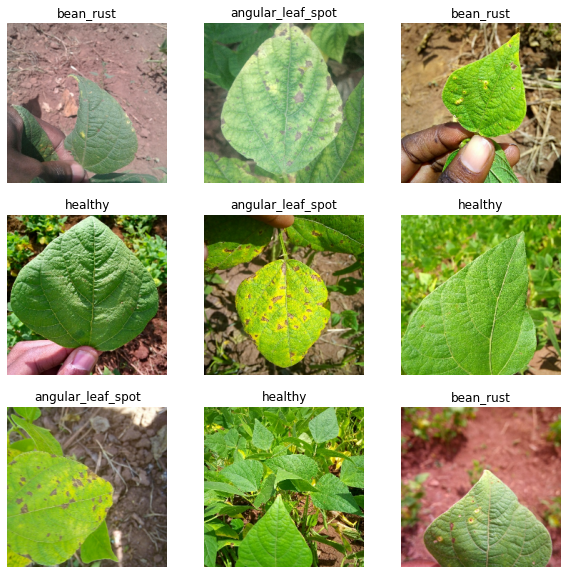

In [28]:
# To print each of the images corresponding to its label
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):

  for i in range(9):

    ax = plt.subplot(3, 3, i + 1)

    plt.imshow(images[i].numpy().astype("uint8"))

    plt.title(classes[labels[i]])

    plt.axis("off")

## What is tf.data?

**Introduction:**

GPUs and TPUs can radically reduce the time required to execute a single training step. Achieving peak performance requires an efficient input pipeline that delivers data for the next step before the current step has finished. The tf.data API helps to build flexible and efficient input pipelines. 

**The naive approach**

In a naive synchronous implementation like here, while your pipeline is fetching the data, your model is sitting idle. Conversely, while your model is training, the input pipeline is sitting idle. The training step time is thus the sum of opening, reading and training times. The following diagram explains the naive approach:
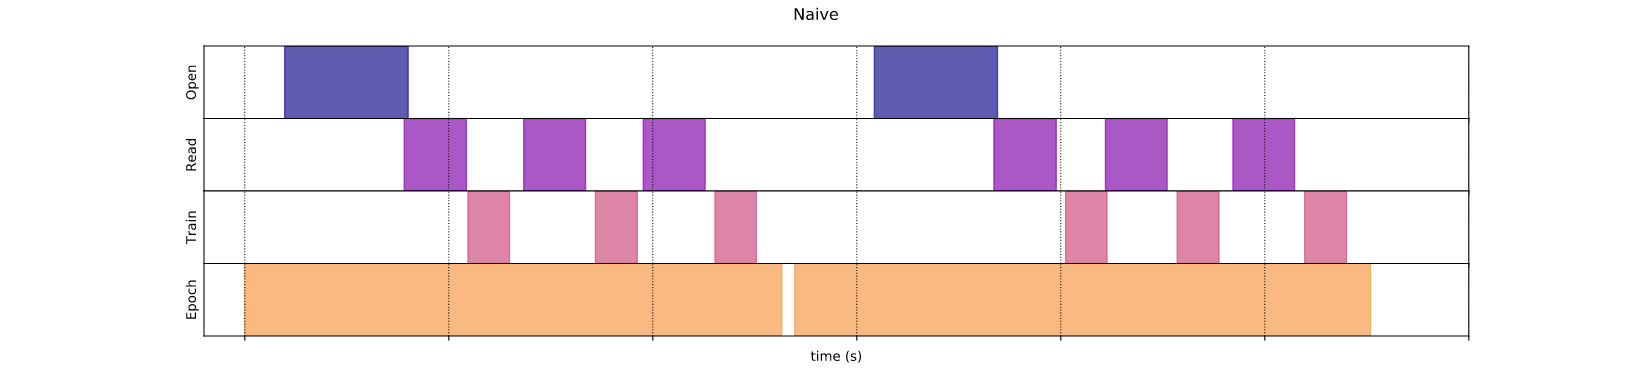

Now what is **prefetching**?

Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

The tf.data API provides the tf.data.Dataset.prefetch transformation. It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to tf.data.AUTOTUNE, which will prompt the tf.data runtime to tune the value dynamically at runtime.

The following diagram explains how prefetching helps:
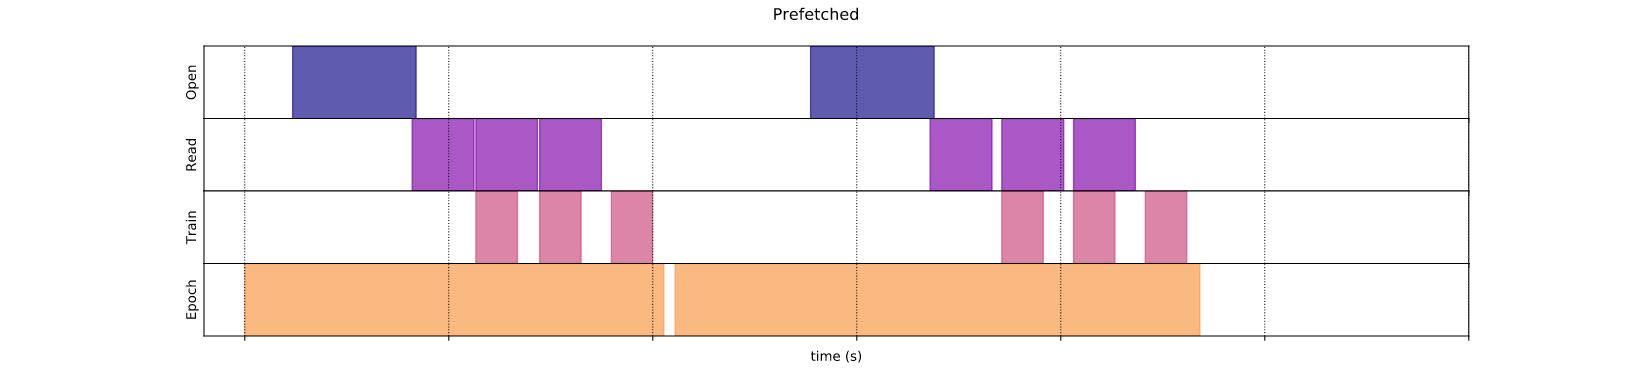


In [29]:
AUTOTUNE = tf.data.AUTOTUNE


# For the train data
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# For the validation data
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Building the model

TensorFlow Hub:

TensorFlow Hub is a repository of trained machine learning models ready for fine-tuning and deployable anywhere. 

1. Selecting the model:

In [30]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" # Here we use the mobilenet_v2

2. This layer wraps a callable object for use as a Keras layer. The callable object can be passed directly,

In [31]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(img_height,img_width,3))

3. This parameter is a  boolean controlling whether this layer is trainable. Must not be set to True when using a signature (raises ValueError), including the use of legacy TF1 Hub format.

In [32]:
feature_extractor_layer.trainable = False

4. Setting a layer for Scaling the images.

In [33]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

5. Setting the seeds such that we could reproduce the same result.

In [34]:
tf.random.set_seed(121)

6. Finally creating the model instance by combining all the layers. The fourth layer is the output layer.

In [35]:
model = tf.keras.Sequential([
    normalization_layer,
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3,activation = 'softmax')
])

7. Compilling the model by setting the parameters like loss function,optimizer and the metric to be used.

In [36]:
model.compile(loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = 'adam',
              metrics = ['accuracy'])

8. Finally fitting the model 

In [37]:
history = model.fit(train_ds,epochs = 30,validation_data = val_ds)

Epoch 1/30
9/9 [==============================] - 16s 329ms/step - loss: 1.3091 - accuracy: 0.3791 - val_loss: 0.9058 - val_accuracy: 0.5714
Epoch 2/30
9/9 [==============================] - 1s 148ms/step - loss: 0.8565 - accuracy: 0.6161 - val_loss: 0.6598 - val_accuracy: 0.7519
Epoch 3/30
9/9 [==============================] - 1s 147ms/step - loss: 0.6750 - accuracy: 0.7205 - val_loss: 0.5682 - val_accuracy: 0.7820
Epoch 4/30
9/9 [==============================] - 1s 146ms/step - loss: 0.5659 - accuracy: 0.7737 - val_loss: 0.5069 - val_accuracy: 0.8195
Epoch 5/30
9/9 [==============================] - 1s 147ms/step - loss: 0.4997 - accuracy: 0.7911 - val_loss: 0.4669 - val_accuracy: 0.8195
Epoch 6/30
9/9 [==============================] - 1s 146ms/step - loss: 0.4839 - accuracy: 0.8133 - val_loss: 0.4387 - val_accuracy: 0.8271
Epoch 7/30
9/9 [==============================] - 1s 147ms/step - loss: 0.4190 - accuracy: 0.8356 - val_loss: 0.4151 - val_accuracy: 0.8421
Epoch 8/30
9/9 [===

# Evaluating the model performance.


Plotting the training and the validation accuracy, to infer whether there is overfitting or underfitting.

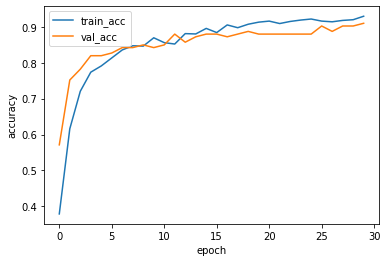

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc','val_acc'])
plt.show()

# Predicting the test data and comparing the predictions with their true values

1/1 [==============================] - 0s 20ms/step


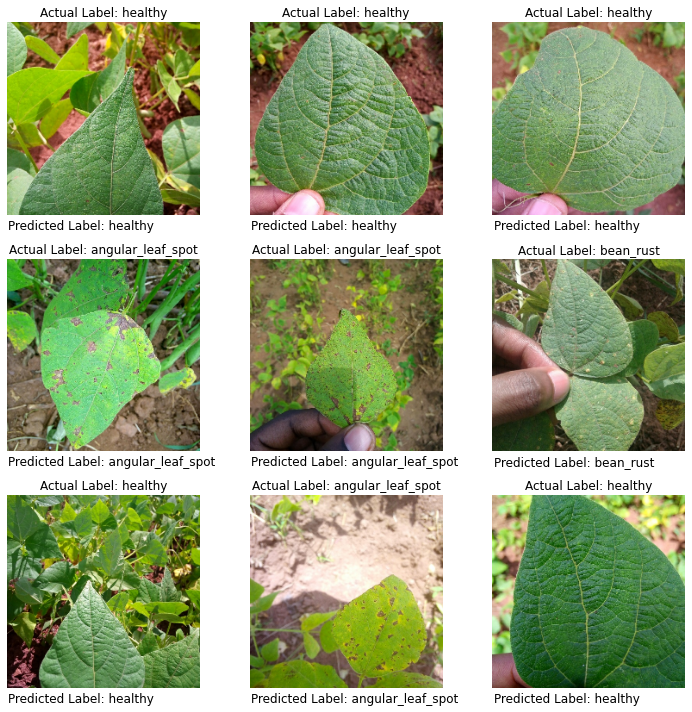

In [39]:
plt.figure(figsize=(10, 10))

for images, labels in test_ds.take(1):

  for i in range(9):

    ax = plt.subplot(3, 3, i + 1)



    plt.tight_layout()

    

    img = tf.keras.preprocessing.image.img_to_array(images[i])                    

    img = np.expand_dims(img, axis=0)  



    pred=model.predict(img)

    plt.imshow(images[i].numpy().astype("uint8"))

    plt.title("Actual Label: %s" % classes[labels[i]])

    plt.text(1, 240, "Predicted Label: %s" % classes[np.argmax(pred)], fontsize=12)



    plt.axis("off")

In [40]:
model.summary()  # This gives the model summary
                # Information about the parameters in each layer

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


# Saving the model and Loading model

## **Saving the model and its artifacts**

In [41]:
model.save('./models',save_format = 'tf') # The model will be saved in .tf format

In [42]:
!ls -alrt models                          # listing all the files in the models folder

total 1888
drwxr-xr-x 1 root root    4096 Dec 21 16:56 ..
drwxr-xr-x 2 root root    4096 Dec 21 16:56 variables
drwxr-xr-x 2 root root    4096 Dec 21 16:56 assets
-rw-r--r-- 1 root root 1906484 Dec 21 16:56 saved_model.pb
-rw-r--r-- 1 root root    6922 Dec 21 16:56 keras_metadata.pb
drwxr-xr-x 4 root root    4096 Dec 21 16:56 .


## **Loading the saved model** 

In [43]:
model_loaded = tf.keras.models.load_model('./models/') 

In [44]:
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


Now since we have not made any transformation on the image on which we are gonna make our prediction, we have to make the image compatible with the model. So we create a custom function to make the transformations.

In [65]:
def process(filename):

   np_image = Image.open(filename)

   np_image = np.array(np_image).astype('float32')           # converting the data type to float

   np_image = transform.resize(np_image, (224, 224, 3))      # Resizing the image

   np_image = np.expand_dims(np_image, axis=0)               # Insert a new axis that will appear at the axis position in the expanded array shape.

   return np_image

In [55]:
np_image = Image.open('beans/train/healthy/healthy_train.0.jpg')
np_image = np.array(np_image)

In [56]:
np_image.shape

(500, 500, 3)

In [57]:
# Thus, applying the custom function to the image does all the transformation
process('beans/train/healthy/healthy_train.0.jpg').shape

(1, 224, 224, 3)

Predicting the class of the image.

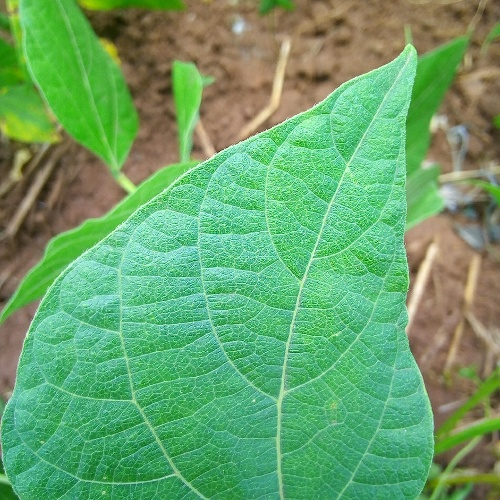

In [60]:
display(Image('beans/train/healthy/healthy_train.0.jpg'))

In [71]:
pred_label = model_loaded.predict(process('beans/train/healthy/healthy_train.0.jpg'))

1/1 [==============================] - 1s 734ms/step


In [72]:
pred_label

array([[2.4314615e-04, 1.9741787e-02, 9.8001510e-01]], dtype=float32)

**Interpretation:** The model predicts that the crop is healthy.

## Zipping the model and its artifacts.

In [73]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/assets/ (stored 0%)
  adding: models/keras_metadata.pb (deflated 82%)
  adding: models/variables/ (stored 0%)
  adding: models/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: models/variables/variables.index (deflated 78%)
  adding: models/saved_model.pb (deflated 92%)


# **Conclusion:** 

Thus, we have successfully build a model, tested the model performance and saved the model and its artifacts as a ZIP file. This zip file could be sent to anyone, so that they it could be loaded and directly used for prediction. There no need for training the model again. The model could be further deployed too.